### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar10 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 2

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [3]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[i]) / (i + 1) for i in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
    return np.mean(cumulative_averages, axis=0)

In [5]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [6]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(cumulative_averages, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [7]:
def plot_cumulative_subplots(accuracy_arrays, subtitles, plot_filename=""):
    assert len(accuracy_arrays) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    labels = ["Without Drift", "With Drift", "Drift with Full Relearning", "Drift with Buffer Resampling"]

    cumulative_averages = []

    for acc_array in accuracy_arrays:
        cum_avg_acc = [np.nansum(acc_array[i]) / (i + 1) for i in range(len(acc_array))]
        cumulative_averages.append(cum_avg_acc)

    fig, axes = plt.subplots(1, len(accuracy_arrays) // 4, figsize=(12, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                "--o" if j == 0 else "-o",
                label=f"{labels[j]}: {cumulative_averages[4 * i + j][-1]:.2f}%",
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=14)
            axes[i].legend(prop={"size": 8}, loc="lower left")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 101, 5)))

    fig.supxlabel("Task Trained On", fontsize=14)
    fig.supylabel("Accuracy (%)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

In [8]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

# ER

## Buffer 500

### Accuracy Without Drift

In [46]:
er_500_accuracy_array_without_drift = read_results(
    "./logs/01-23-25-03-17-48-seq-cifar10-er-buf-500-drift-6-n-2-adaptation-0.json"
)
# 33.97, 34.09, 34.25
# 34.10333333333333 ± 0.11469767022723534
# plot_results(
#     er_500_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_500_accuracy_array_without_drift)[1]

75.2875

### Permutation Drift in Tasks 2, 4

In [47]:
er_500_accuracy_array_with_drift = read_results(
    "./logs/01-23-25-04-53-49-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-0.json"
)
# 29.03, 29.16, 29.76
# 29.316666666666666 ± 0.3179447890576116
# plot_results(
#     er_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4",
# )
average_forgetting(er_500_accuracy_array_with_drift)[1]

81.525

### Permutation Drift in Tasks 2, 4 with Full Relearning

In [48]:
# before reimplementation
# er_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-06-21-58-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-1.json"
# ) # 46.31, 47.64, 47.91
# # 47.28666666666667 ± 0.6993489035444941

3 files found
1: ./reimplementation-logs/02-19-25-15-46-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-15-02-41-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-14-20-44-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 46.883333333333326
Avg Forgetting: 58.949999999999996


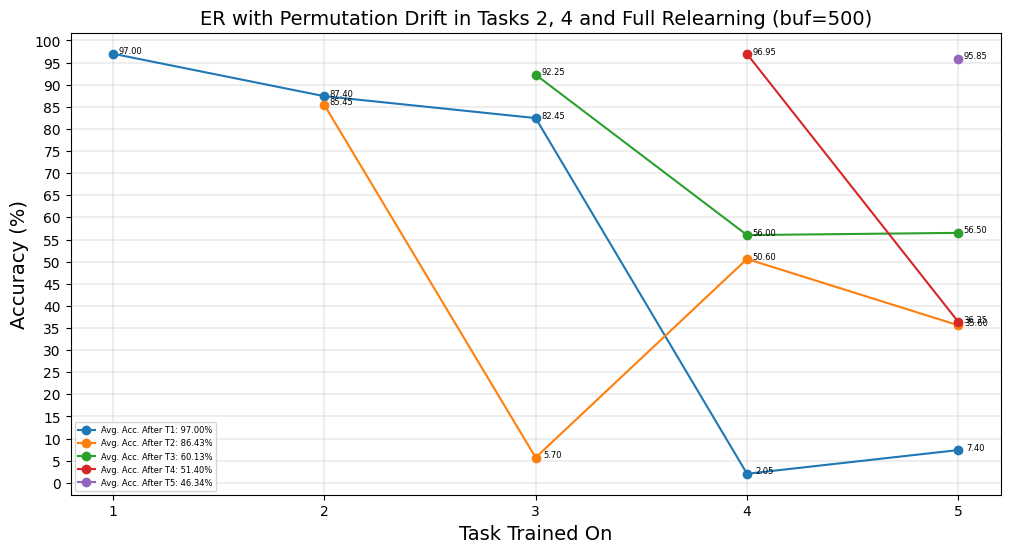

In [49]:
er_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-15-46-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
# 46.30, 46.34, 48.01
plot_results(
    er_500_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [50]:
## before reimplementation
# er_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-07-27-40-seq-cifar10-er-buf-500-drift-5-n-2-adaptation-2.json"
# ) # 46.90, 47.75, 48.14
# # 47.59666666666667 ± 0.5177086267604811

3 files found
1: ./reimplementation-logs/02-19-25-16-14-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-16-42-54-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-17-11-44-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 49.25
Avg Forgetting: 55.35


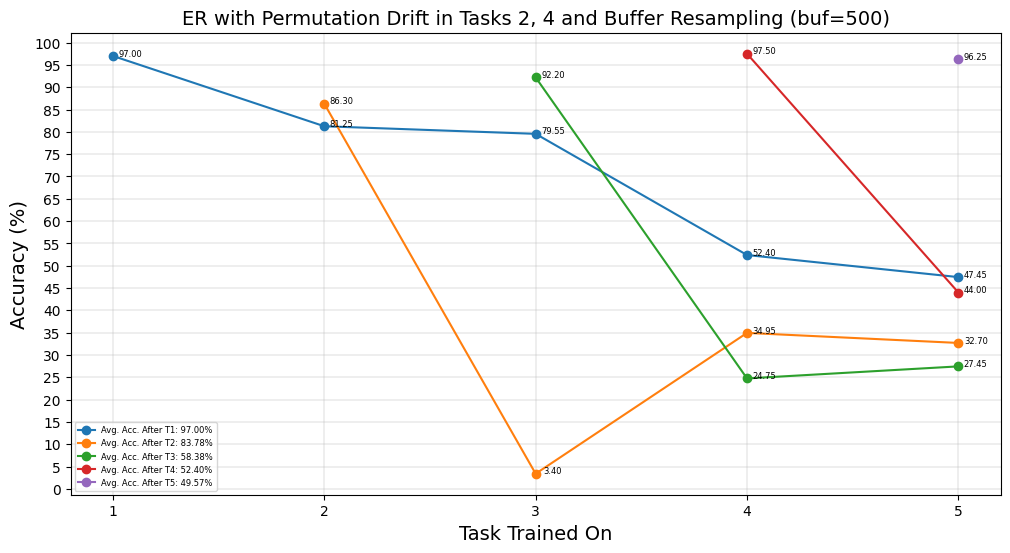

In [51]:
er_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-16-14-05-seq-cifar10-er-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
# 48.41, 49.57, 49.77
plot_results(
    er_500_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

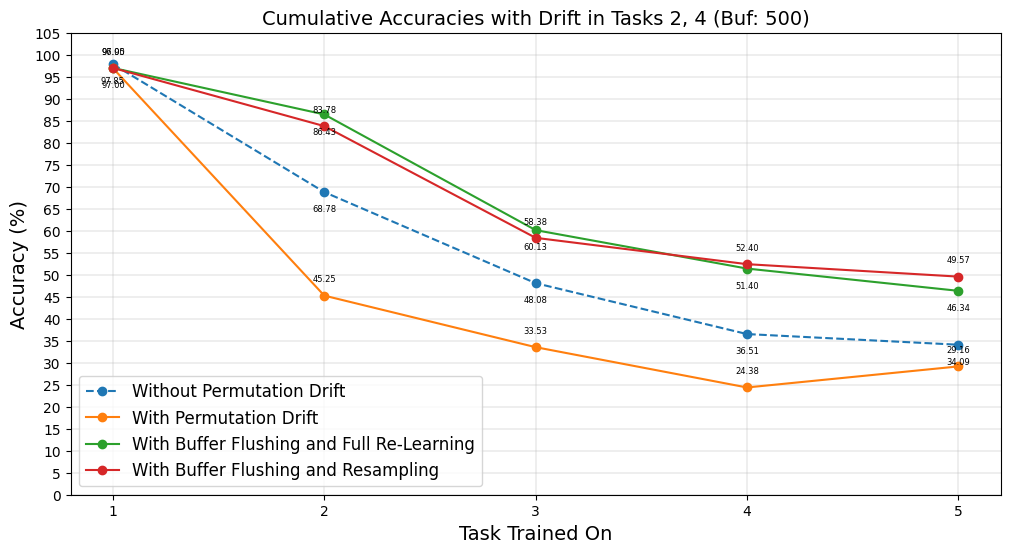

In [61]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [53]:
er_5000_accuracy_array_without_drift = read_results(
    "./logs/01-23-25-08-51-55-seq-cifar10-er-buf-5000-drift-6-n-2-adaptation-0.json"
)
# 65.74, 65.78, 67.32
# 66.27999999999999 ± 0.7355723395198214
# plot_results(
#     er_5000_accuracy_array_without_drift,
#     title="ER Baseline CIL Accuracy",
# )
average_forgetting(er_5000_accuracy_array_without_drift)[1]

33.8625

### Permutation Drift in Tasks 2, 4

In [54]:
er_5000_accuracy_array_with_drift = read_results(
    "./logs/01-23-25-11-13-13-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-0.json"
)
# 35.97, 36.09, 36.33
# 36.13 ± 0.14966629547095697
# plot_results(
#     er_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4",
# )
average_forgetting(er_5000_accuracy_array_with_drift)[1]

71.0

### Permutation Drift in Tasks 2, 4 with Full Relearning

In [55]:
## before reimplementation
# er_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-13-28-15-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-1.json"
# ) # 64.39, 64.73, 66.26
# # 65.12666666666667 ± 0.8133196720164165

3 files found
1: ./reimplementation-logs/02-19-25-14-22-37-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-15-06-50-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-15-53-35-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 63.199999999999996
Avg Forgetting: 36.2375


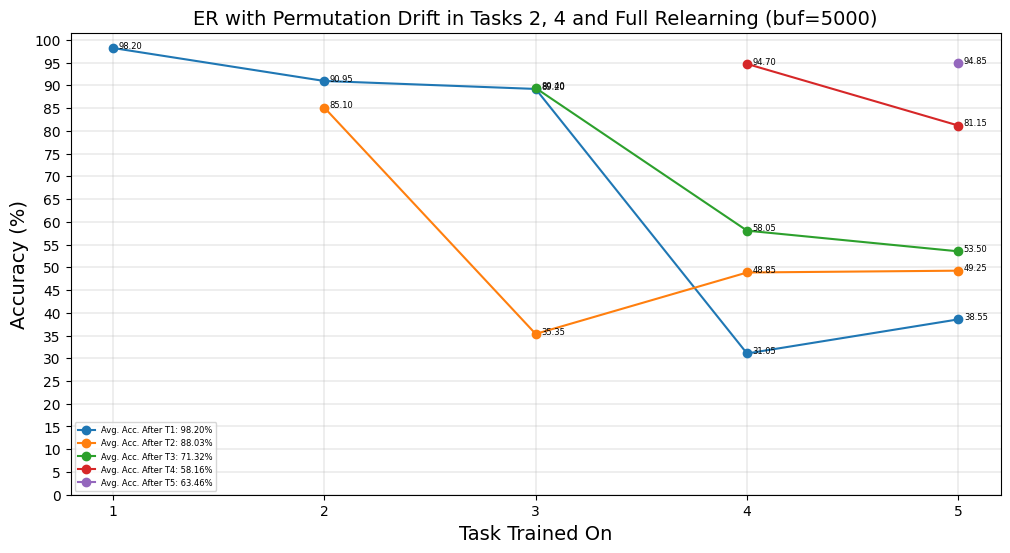

In [56]:
er_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-15-53-35-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
# 62.48, 63.46, 63.66
plot_results(
    er_5000_accuracy_array_with_drift_full_relearning,
    title="ER with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [57]:
## before reimplementation
# er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-14-51-31-seq-cifar10-er-buf-5000-drift-5-n-2-adaptation-2.json"
# ) # 64.39, 64.88, 65.05
# # 64.77333333333333 ± 0.2798015169524424

3 files found
1: ./reimplementation-logs/02-19-25-16-21-10-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-16-49-20-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-17-17-30-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 65.26666666666667
Avg Forgetting: 35.475


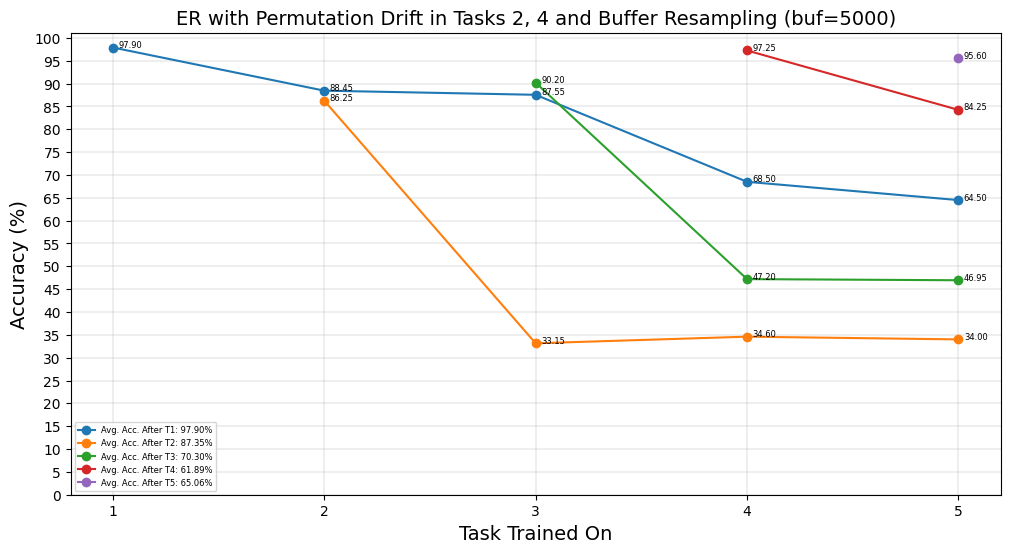

In [58]:
er_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-16-21-10-seq-cifar10-er-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
# 64.97, 65.06, 65.77
plot_results(
    er_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

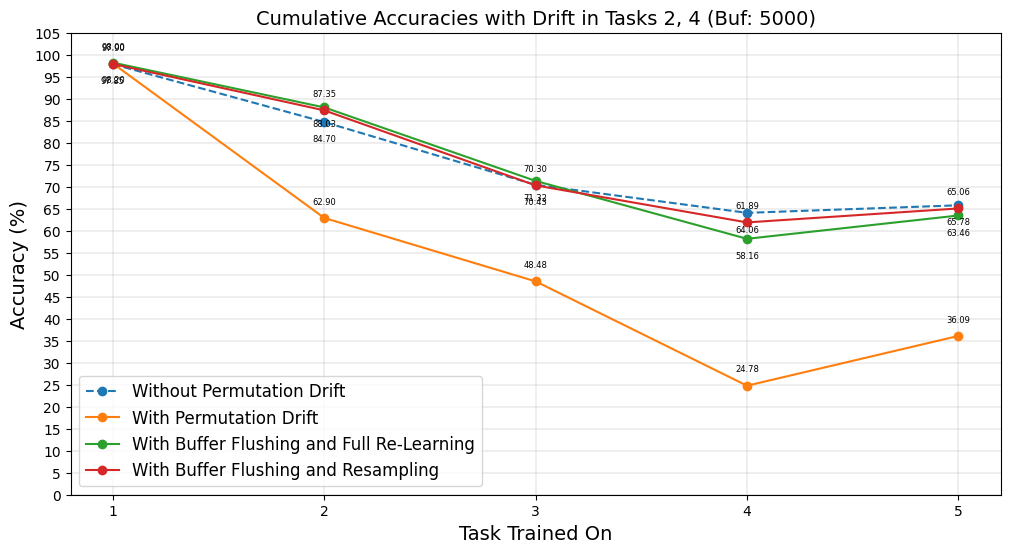

In [62]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# ER-ACE

## Buffer 500

### Accuracy Without Drift

In [63]:
er_ace_500_accuracy_array_without_drift = read_results(
    "./logs/01-23-25-03-26-15-seq-cifar10-er_ace-buf-500-drift-6-n-2-adaptation-0.json"
)
# 55.81, 56.50, 57.32
# 56.54333333333333 ± 0.6172159715655086
# plot_results(
#     er_ace_500_accuracy_array_without_drift,
#     title="ER-ACE Baseline CIL Accuracy",
# )
average_forgetting(er_ace_500_accuracy_array_without_drift)[1]

30.962500000000006

### Permutation Drift in Tasks 2, 4

In [64]:
er_ace_500_accuracy_array_with_drift = read_results(
    "./logs/01-23-25-07-12-47-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-0.json"
)
# 29.70, 31.07, 31.51
# 30.76 ± 0.7707572034477965
# plot_results(
#     er_ace_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4",
# )
average_forgetting(er_ace_500_accuracy_array_with_drift)[1]

64.025

### Permutation Drift in Tasks 2, 4 with Full Relearning

In [65]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-08-37-10-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-1.json"
# )
# # 57.26, 58.55, 59.00
# # 58.27 ± 0.7374279625834654

3 files found
1: ./reimplementation-logs/02-19-25-14-53-39-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-17-23-38-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-16-10-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 53.89666666666667
Avg Forgetting: 38.73750000000001


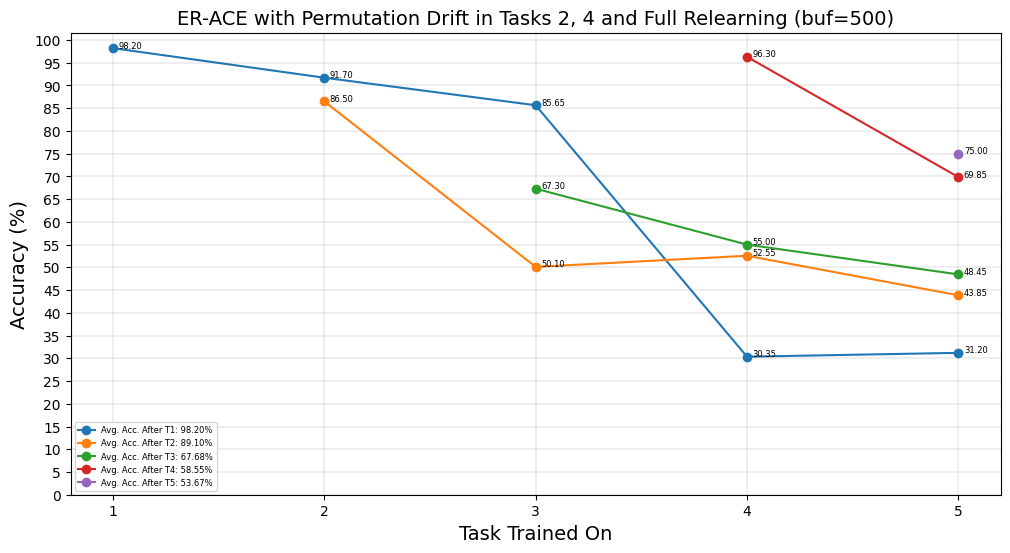

In [66]:
er_ace_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-16-10-28-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
# 52.50, 53.67, 55.52
plot_results(
    er_ace_500_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [67]:
# before reimplementation
# er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-12-18-04-seq-cifar10-er_ace-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 49.05, 51.85, 52.26
# # 51.053333333333335 ± 1.4264252132126982

3 files found
1: ./reimplementation-logs/02-19-25-18-11-33-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-18-57-02-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-19-43-26-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 50.620000000000005
Avg Forgetting: 43.8625


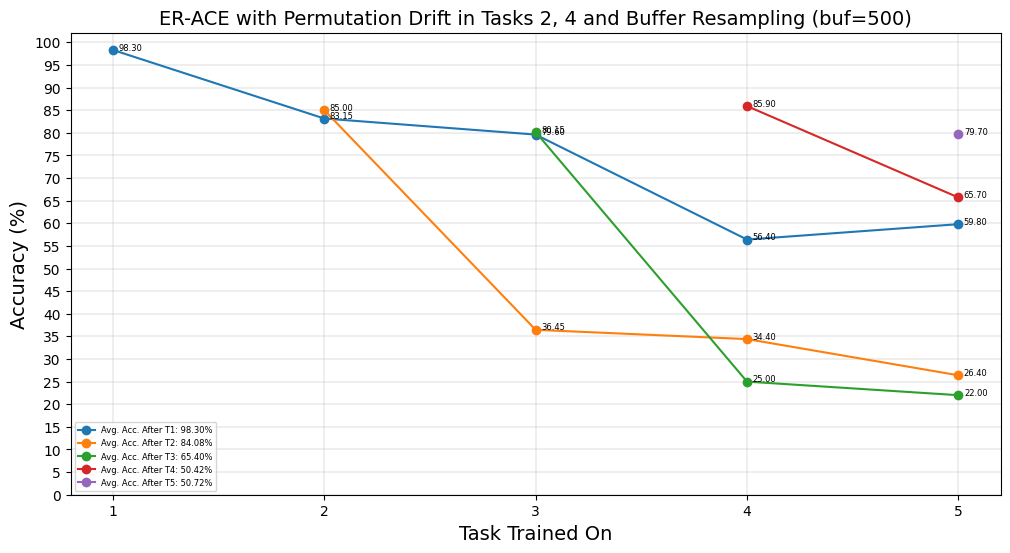

In [68]:
er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_ace_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-18-57-02-seq-cifar10-er_ace-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
# 50.33, 50.72, 50.81
plot_results(
    er_ace_500_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

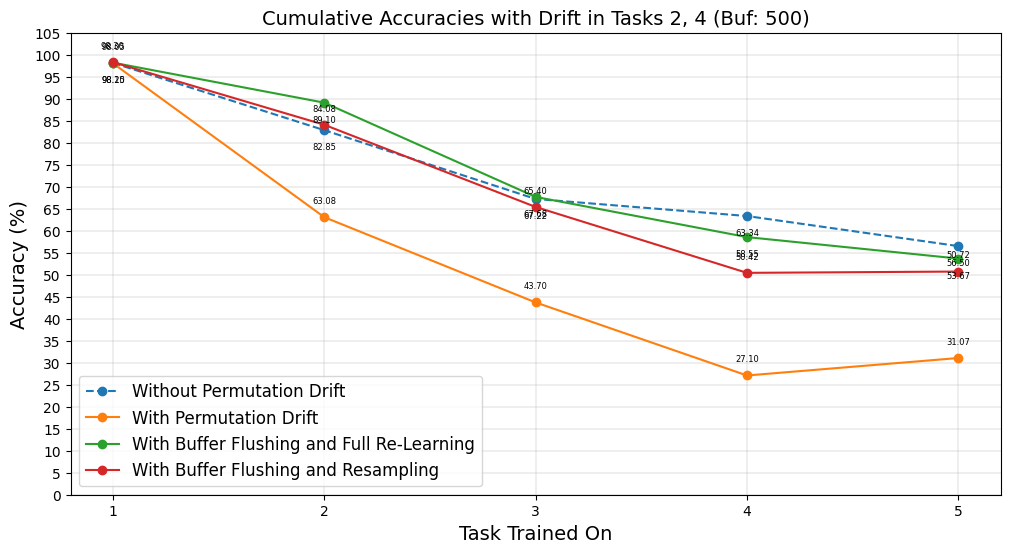

In [69]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 500)",
    [
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [70]:
er_ace_5000_accuracy_array_without_drift = read_results(
    "./logs/01-23-25-16-08-45-seq-cifar10-er_ace-buf-5000-drift-6-n-2-adaptation-0.json"
)
# 68.05, 68.81, 69.70
# 68.85333333333334 ± 0.6743062278289382
# plot_results(
#     er_ace_5000_accuracy_array_without_drift,
#     title="ER-ACE Baseline CIL Accuracy",
# )
average_forgetting(er_ace_5000_accuracy_array_without_drift)[1]

16.550000000000004

### Permutation Drift in Tasks 2, 4

In [71]:
er_ace_5000_accuracy_array_with_drift = read_results(
    "./logs/01-23-25-18-13-47-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-0.json"
)
# 31.87, 32.31, 32.92
# 32.36666666666667 ± 0.4305293898859354
# plot_results(
#     er_ace_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4",
# )
average_forgetting(er_ace_5000_accuracy_array_with_drift)[1]

59.8125

### Permutation Drift in Tasks 2, 4 with Full Relearning

In [72]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-20-32-36-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-1.json"
# )
# # 65.54, 65.70, 66.35
# # 65.86333333333333 ± 0.3502697373295121

3 files found
1: ./reimplementation-logs/02-19-25-14-51-11-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-16-03-18-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-17-14-57-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 61.31
Avg Forgetting: 27.787499999999998


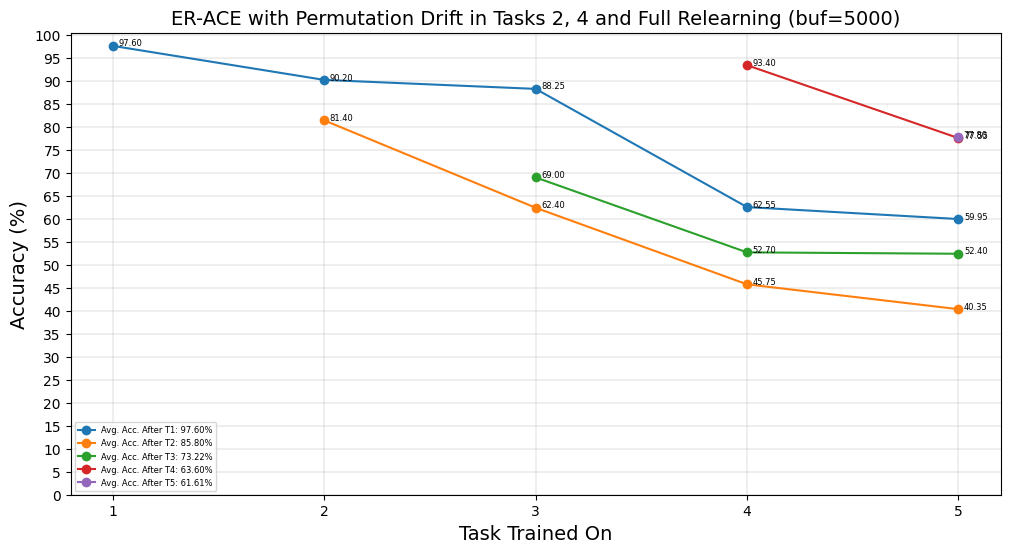

In [73]:
er_ace_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-17-14-57-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
# 60.28, 61.61, 62.04
plot_results(
    er_ace_5000_accuracy_array_with_drift_full_relearning,
    title="ER-ACE with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [74]:
# before reimplementation
# er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-19-16-46-seq-cifar10-er_ace-buf-5000-drift-5-n-2-adaptation-2.json"
# ) # 64.35, 64.45, 64.82
# # 64.54 ± 0.20

3 files found
1: ./reimplementation-logs/02-19-25-19-34-53-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-18-01-49-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-18-49-06-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 65.27
Avg Forgetting: 28.2


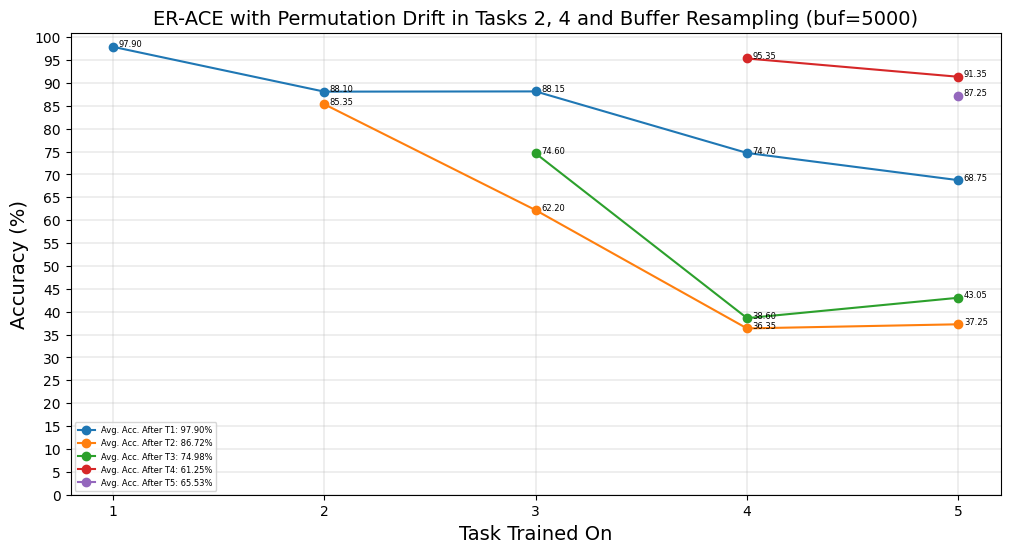

In [75]:
er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {er_ace_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

er_ace_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-19-34-53-seq-cifar10-er_ace-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
# 64.63, 65.53, 65.65
plot_results(
    er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    title="ER-ACE with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(er_ace_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

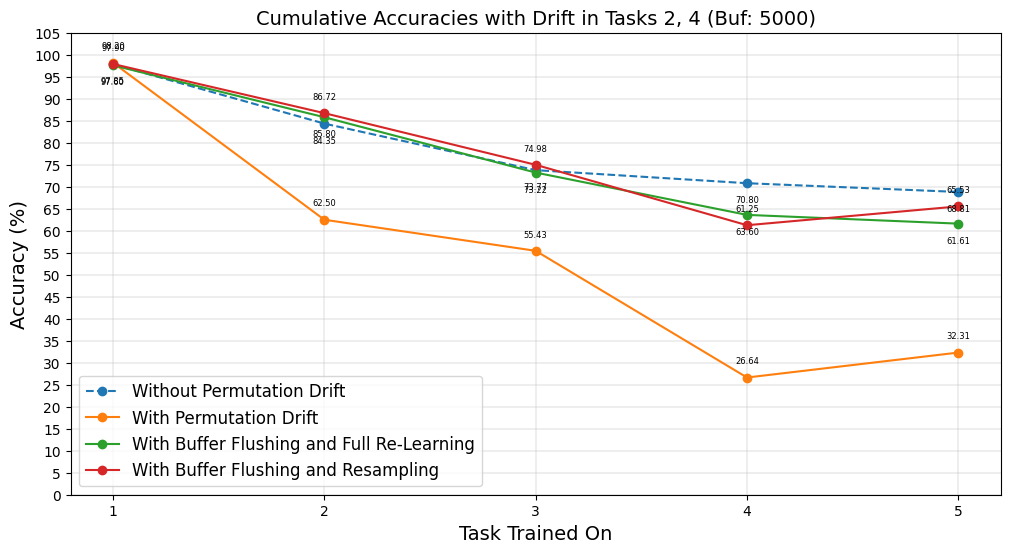

In [76]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 2, 4 (Buf: 5000)",
    [
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# DER++

## Buffer 500

### Accuracy Without Drift

In [77]:
derpp_500_accuracy_array_without_drift = read_results(
    "./logs/01-23-25-04-51-27-seq-cifar10-derpp-buf-500-drift-6-n-2-adaptation-0.json"
)
# 39.43, 39.94, 43.46
# 40.943333333333335 ± 1.791690697513262
# plot_results(
#     derpp_500_accuracy_array_without_drift,
#     title="DER++ Baseline CIL Accuracy",
# )
average_forgetting(derpp_500_accuracy_array_without_drift)[1]

65.71249999999999

### Permutation Drift in Tasks 2, 4

In [78]:
derpp_500_accuracy_array_with_drift = read_results(
    "./logs/01-23-25-07-47-44-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-0.json"
)
# 29.58, 29.86, 30.78
# 30.073333333333334 ± 0.5125968743130968
# plot_results(
#     derpp_500_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4",
# )
average_forgetting(derpp_500_accuracy_array_with_drift)[1]

78.15

### Permutation Drift in Tasks 2, 4 with Full Relearning

In [79]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-07-37-31-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-1.json"
# ) # 52.31, 52.48, 52.71
# # 52.5 ± 0.16391054470858957

3 files found
1: ./reimplementation-logs/02-19-25-15-45-24-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-19-58-47-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-17-49-59-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json
FAA: 50.35999999999999
Avg Forgetting: 52.1625


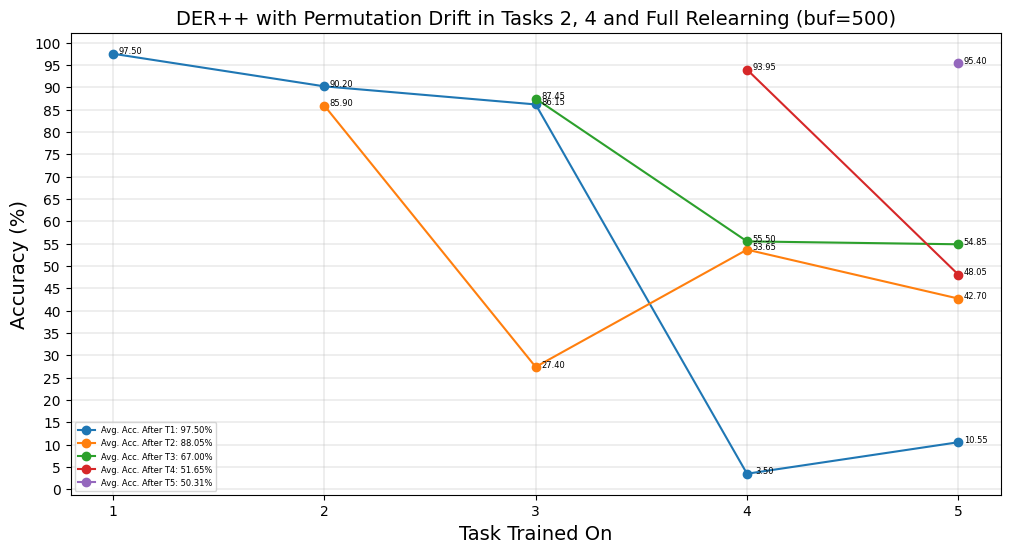

In [80]:
derpp_500_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_500_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-15-45-24-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-1.json"
)
# 48.54, 50.31, 52.23
plot_results(
    derpp_500_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Tasks 2, 4 with Buffer Resampling

In [81]:
# before reimplementation
# derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-10-34-39-seq-cifar10-derpp-buf-500-drift-5-n-2-adaptation-2.json"
# )
# # 51.94, 54.18, 55.43
# # 53.85 ± 1.4437682177782794

3 files found
1: ./reimplementation-logs/02-19-25-21-18-03-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-19-25-23-57-09-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-22-37-45-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json
FAA: 55.356666666666676
Avg Forgetting: 46.55


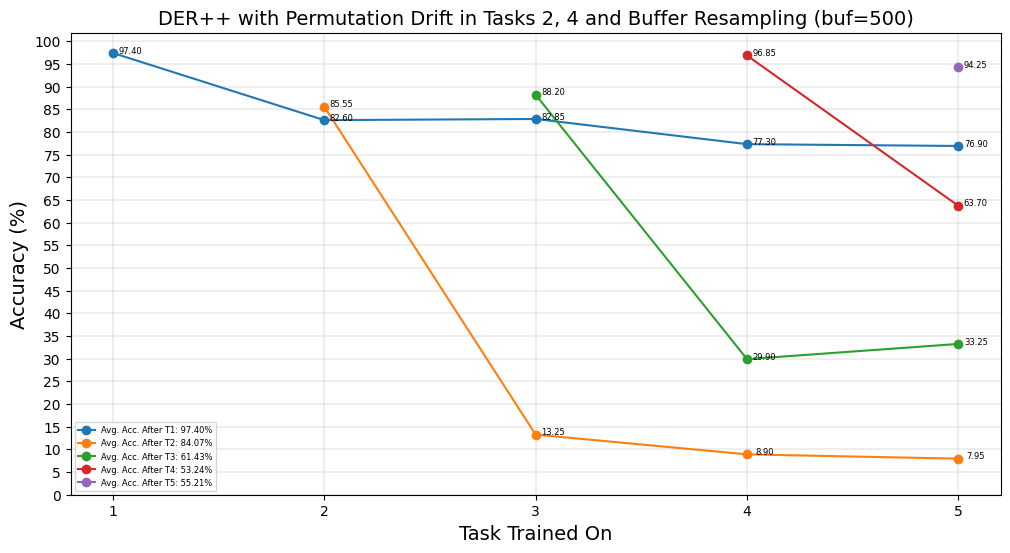

In [82]:
derpp_500_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {derpp_500_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_500_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-22-37-45-seq-cifar10-derpp-buf-500-drift-5-s-5-n-2-adaptation-2.json"
)
# 55.07, 55.21, 55.79
plot_results(
    derpp_500_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=500)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_500_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

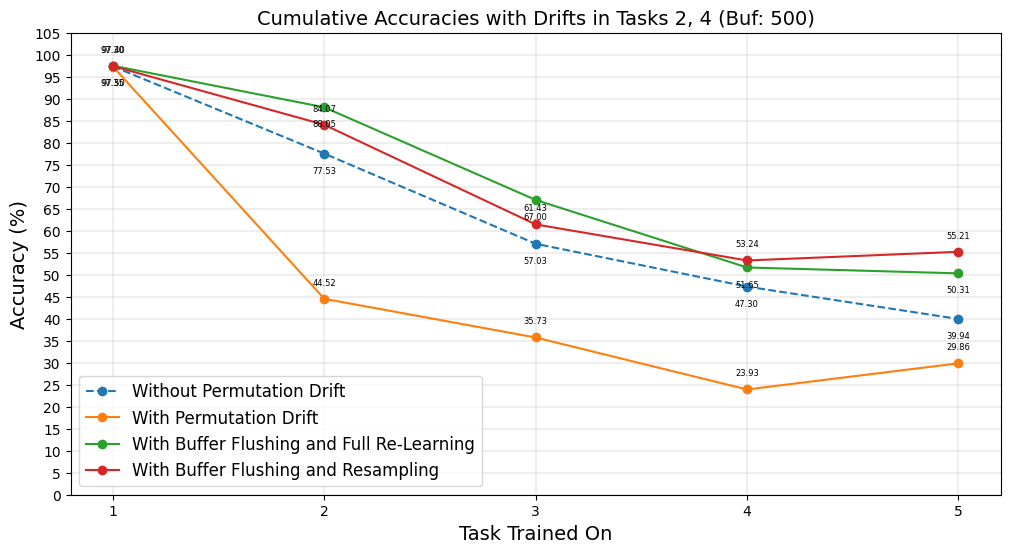

In [83]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Tasks 2, 4 (Buf: 500)",
    [
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

## Buffer 5000

### Accuracy Without Drift

In [84]:
derpp_5000_accuracy_array_without_drift = read_results(
    "./logs/01-23-25-04-53-49-seq-cifar10-derpp-buf-5000-drift-6-n-2-adaptation-0.json"
)
# 65.01, 65.31, 66.03
# 65.45 ± 0.42801869118065244
# plot_results(
#     derpp_5000_accuracy_array_without_drift,
#     title="DER++ Baseline CIL Accuracy",
# )
average_forgetting(derpp_5000_accuracy_array_without_drift)[1]

30.337499999999995

### Permutation Drift in Tasks 2, 4

In [85]:
derpp_5000_accuracy_array_with_drift = read_results(
    "./logs/01-23-25-08-46-36-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-0.json"
)
# 35.07, 35.10, 35.57
# 35.24666666666667 ± 0.22895899681432505
# plot_results(
#     derpp_5000_accuracy_array_with_drift,
#     title="Accuracy with Permutation Drift in Tasks 2, 4",
# )
average_forgetting(derpp_5000_accuracy_array_with_drift)[1]

67.98750000000001

### Permutation Drift in Tasks 2, 4 with Adaptive Re-Learning

In [86]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
#     "./logs/01-23-25-04-32-39-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-1.json"
# ) # 64.59, 65.39, 66.49
# # 65.49000000000001 ± 0.778888096369858

3 files found
1: ./reimplementation-logs/02-19-25-17-51-03-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
2: ./reimplementation-logs/02-19-25-15-45-46-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
3: ./reimplementation-logs/02-19-25-20-01-25-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json
FAA: 64.12
Avg Forgetting: 32.47500000000001


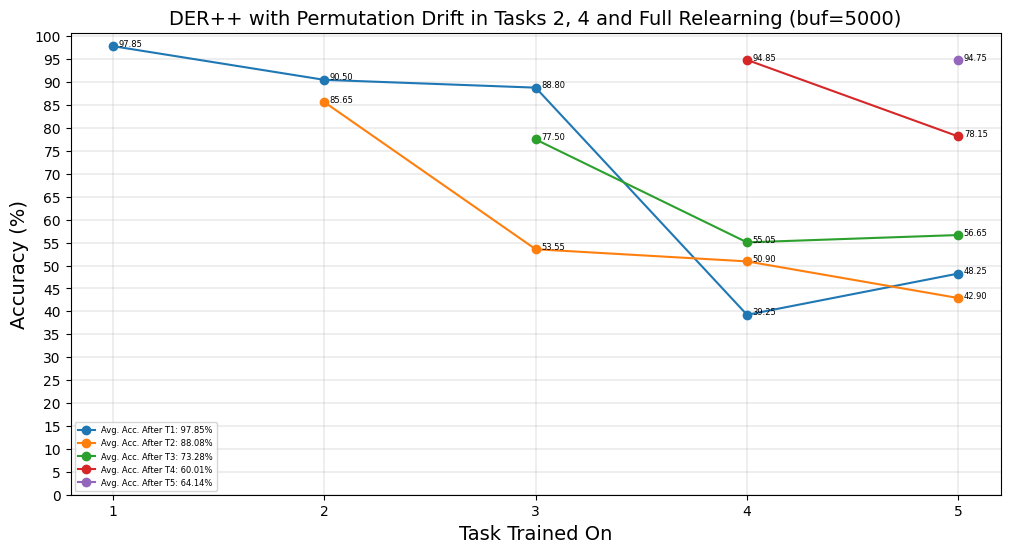

In [87]:
derpp_5000_accuracy_array_with_drift_full_relearning_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_full_relearning_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_full_relearning = read_results(
    "./reimplementation-logs/02-19-25-15-45-46-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-1.json"
)
# 63.17, 64.14, 65.05
plot_results(
    derpp_5000_accuracy_array_with_drift_full_relearning,
    title="DER++ with Permutation Drift in Tasks 2, 4 and Full Relearning (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_full_relearning)[1]}")

### Permutation Drift in Tasks 2, 4 with Adaptive Buffer Resampling

In [88]:
# before reimplementation
# derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
#     "./logs/01-23-25-08-38-41-seq-cifar10-derpp-buf-5000-drift-5-n-2-adaptation-2.json"
# )
# # 65.09, 65.12, 66.95
# # 65.72000000000001 ± 0.8698275691193049

3 files found
1: ./reimplementation-logs/02-19-25-21-21-29-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
2: ./reimplementation-logs/02-20-25-00-01-41-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
3: ./reimplementation-logs/02-19-25-22-41-56-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json
FAA: 64.24
Avg Forgetting: 34.75


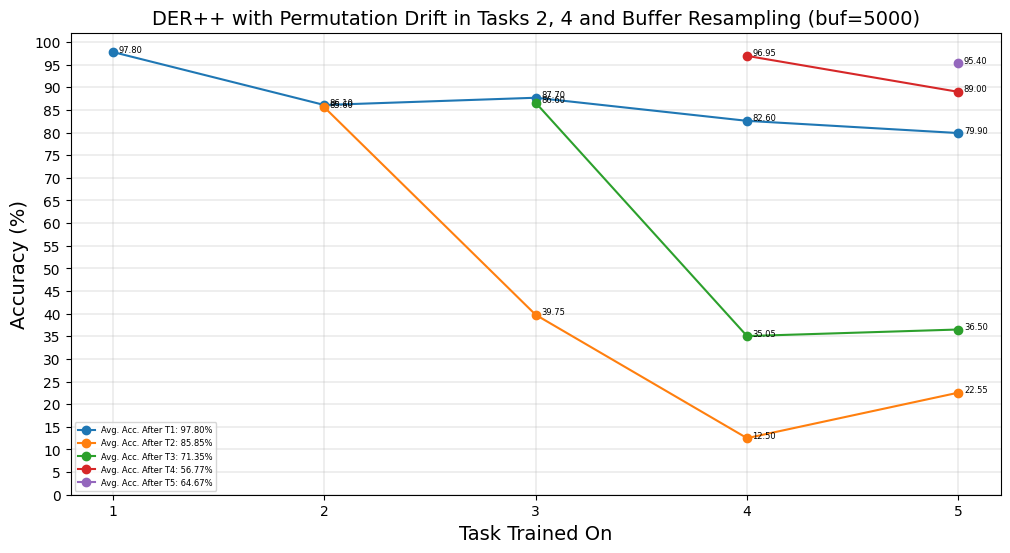

In [89]:
derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs = cumulative_average_multiple_runs(
    "./reimplementation-logs/*-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
print(f"FAA: {derpp_5000_accuracy_array_with_drift_buffer_resampling_avgs[-1]}")

derpp_5000_accuracy_array_with_drift_buffer_resampling = read_results(
    "./reimplementation-logs/02-19-25-21-21-29-seq-cifar10-derpp-buf-5000-drift-5-s-5-n-2-adaptation-2.json"
)
# 63.36, 64.67, 64.69
plot_results(
    derpp_5000_accuracy_array_with_drift_buffer_resampling,
    title="DER++ with Permutation Drift in Tasks 2, 4 and Buffer Resampling (buf=5000)",
)
print(f"Avg Forgetting: {average_forgetting(derpp_5000_accuracy_array_with_drift_buffer_resampling)[1]}")

### Cumulative Plots

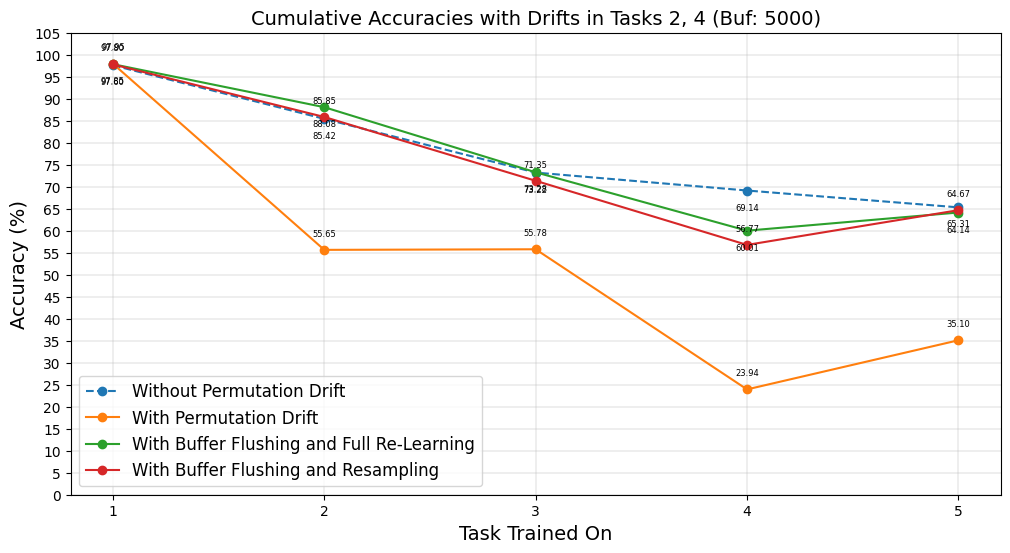

In [90]:
plot_cumulative_results(
    "Cumulative Accuracies with Drifts in Tasks 2, 4 (Buf: 5000)",
    [
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

## Buffer 500

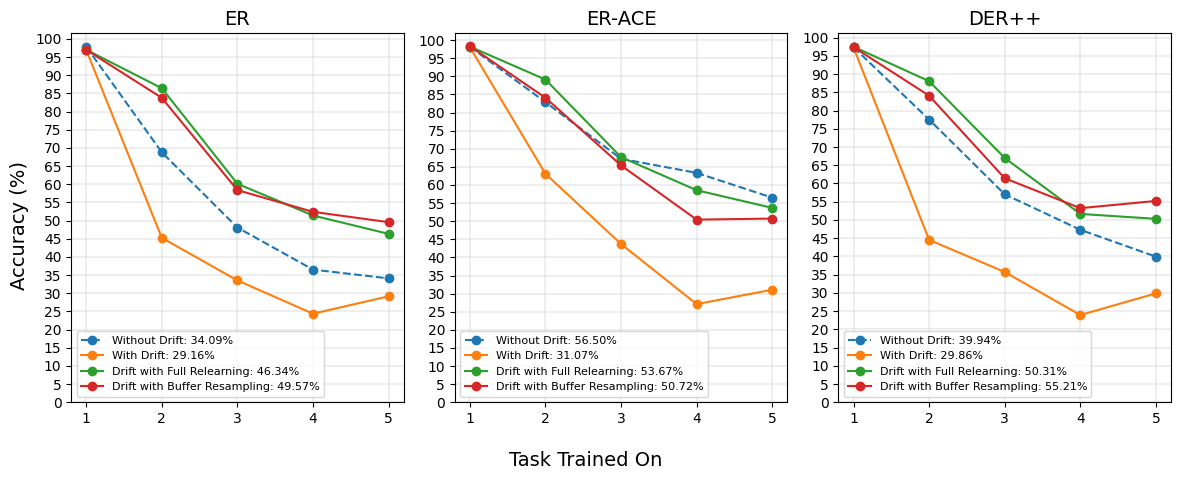

In [92]:
plot_cumulative_subplots(
    [
        er_500_accuracy_array_without_drift,
        er_500_accuracy_array_with_drift,
        er_500_accuracy_array_with_drift_full_relearning,
        er_500_accuracy_array_with_drift_buffer_resampling,
        er_ace_500_accuracy_array_without_drift,
        er_ace_500_accuracy_array_with_drift,
        er_ace_500_accuracy_array_with_drift_full_relearning,
        er_ace_500_accuracy_array_with_drift_buffer_resampling,
        derpp_500_accuracy_array_without_drift,
        derpp_500_accuracy_array_with_drift,
        derpp_500_accuracy_array_with_drift_full_relearning,
        derpp_500_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR10_Buff_500_n_2.pdf",
)

## Buffer 5000

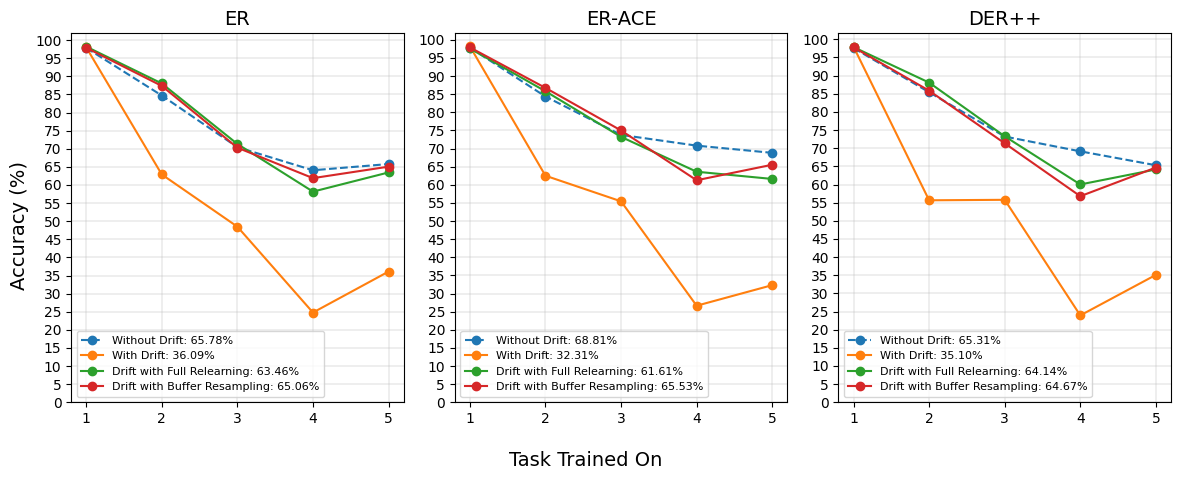

In [93]:
plot_cumulative_subplots(
    [
        er_5000_accuracy_array_without_drift,
        er_5000_accuracy_array_with_drift,
        er_5000_accuracy_array_with_drift_full_relearning,
        er_5000_accuracy_array_with_drift_buffer_resampling,
        er_ace_5000_accuracy_array_without_drift,
        er_ace_5000_accuracy_array_with_drift,
        er_ace_5000_accuracy_array_with_drift_full_relearning,
        er_ace_5000_accuracy_array_with_drift_buffer_resampling,
        derpp_5000_accuracy_array_without_drift,
        derpp_5000_accuracy_array_with_drift,
        derpp_5000_accuracy_array_with_drift_full_relearning,
        derpp_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "ER",
        "ER-ACE",
        "DER++",
    ],
    plot_filename="CIFAR10_Buff_5000_n_2.pdf",
)